In [1]:
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import Ridge
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import pandas as pd
import numpy as np
import warnings
import optuna

matplotlib.style.use('ggplot')
warnings.filterwarnings('ignore')

In [2]:
SEED = 27
N_SPLITS = 5
N_REPEATS = 1

# Loading the Dataset

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s4e5/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s4e5/test.csv', index_col='id')

# Preprocessing
- I'm incorporating a new feature which was suggested [here](https://www.kaggle.com/competitions/playground-series-s4e5/discussion/499274).
- I've also added a few other statistical features which have been suggested on the forums by various people.

In [4]:
def add_stat_features(dataframe, cols):
    dataframe['_sum'] = dataframe[cols].sum(1)
    dataframe['_var'] = dataframe[cols].var(1)
    dataframe['_prod'] = dataframe[cols].prod(1)
    dataframe['_mean'] = dataframe[cols].mean(1)
    dataframe['_skew'] = dataframe[cols].skew(1)
    dataframe['_median'] = dataframe[cols].median(1)

    sorted_features = [f"sort_{i}" for i in np.arange(len(cols))]
    dataframe[sorted_features] = np.sort(dataframe[cols], axis=1)
    
    return dataframe
        
feature_cols = list(test.columns)
target_col = 'FloodProbability'

In [5]:
train = add_stat_features(train, feature_cols)
test = add_stat_features(test, feature_cols)

train = train.drop(feature_cols, axis=1)
test = test.drop(feature_cols, axis=1)

X = train.drop(target_col, axis=1)
y = train[target_col]

# Training

In [6]:
class Trainer:
    def __init__(self, model, X, y, n_splits=N_SPLITS, n_repeats=N_REPEATS):
        self.model = model
        self.X = X
        self.y = y
        self.n_splits = n_splits
        self.n_repeats = n_repeats

    def fit(self):
        skf = KFold(n_splits=self.n_splits, shuffle=True, random_state=SEED)
        
        oof_preds = np.zeros(len(self.X), dtype=float)
        scores = []
        for train_idx, val_idx in skf.split(self.X, self.y):
            X_train, X_val = self.X.iloc[train_idx], self.X.iloc[val_idx]
            y_train, y_val = self.y.iloc[train_idx], self.y.iloc[val_idx]
            
            y_pred = np.zeros_like(y_val, dtype=float)
            
            for i in range(self.n_repeats):
                m = clone(self.model)
                if self.n_repeats > 1:
                    m.set_params(random_state=i)
                m.fit(X_train, y_train)
                y_pred += m.predict(X_val)
                
            y_pred /= self.n_repeats
            
            score = r2_score(y_val, y_pred)
            scores.append(score)
            
            oof_preds[val_idx] = y_pred
            
        return scores, oof_preds
        
    def predict(self, X_test):
        y_pred = np.zeros(len(X_test), dtype=float)
        for i in range(self.n_repeats):
            m = clone(self.model)
            if self.n_repeats > 1:
                m.set_params(random_state=i)
            m.fit(self.X, self.y)
            y_pred += m.predict(X_test)
        y_pred /= self.n_repeats
        return y_pred

In [7]:
xgb_params = {
    'n_jobs': -1,
    'max_depth': 15,
    'max_leaves': 51,
    'n_estimators': 921,
    'random_state': SEED,
    'objective': 'reg:gamma',
    'grow_policy': 'depthwise',
    'gamma': 0.001191175583365525,
    'reg_alpha': 0.4922409840555407,
    'subsample': 0.9043911969552909,
    'reg_lambda': 0.2006103666827618,
    'max_delta_step': 0.5187236006765079,
    'learning_rate': 0.031068537109748533,
    'colsample_bynode': 0.9056076202576685,
    'min_child_weight': 0.1519636306480494,
    'colsample_bytree': 0.8136171314595549,
    'colsample_bylevel': 0.8469915838866402,
}

cb_params = {
    'depth': 10,
    'verbose': False,
    'iterations': 1566,
    'random_state': SEED,
    'min_data_in_leaf': 17,
    'loss_function': 'RMSE',
    'bootstrap_type': 'MVS',
    'grow_policy': 'SymmetricTree',
    'l2_leaf_reg': 1.6916966756596432,
    'learning_rate': 0.02548238769955287,
    'colsample_bylevel': 0.9626458989963868,
}

lgbm_params = {
    'n_jobs': -1,
    'verbose': -1,
    'max_depth': 222,
    'num_leaves': 222,
    'n_estimators': 702,
    'subsample_freq': 7,
    'random_state': SEED,
    'boosting_type': 'gbdt',
    'min_child_samples': 80,
    'subsample': 0.6815709181423294,
    'reg_lambda': 0.00539368681254854,
    'reg_alpha': 0.017697331864994163,
    'learning_rate': 0.02089310186842622,
    'colsample_bytree': 0.4920417554994534,
    'min_child_weight': 0.021791620166345272
}

In [8]:
xgb_model = XGBRegressor(**xgb_params)
xgb_scores, xgb_oof_preds = Trainer(xgb_model, X, y).fit()
print(f'{xgb_model.__class__.__name__}: {np.mean(xgb_scores):.6f} ± {np.std(xgb_scores):.6f}')

cb_model = CatBoostRegressor(**cb_params)
cb_scores, cb_oof_preds = Trainer(cb_model, X, y).fit()
print(f'{cb_model.__class__.__name__}: {np.mean(cb_scores):.6f} ± {np.std(cb_scores):.6f}')

lgbm_model = LGBMRegressor(**lgbm_params)
lgbm_scores, lgbm_oof_preds = Trainer(lgbm_model, X, y).fit()
print(f'{lgbm_model.__class__.__name__}: {np.mean(lgbm_scores):.6f} ± {np.std(lgbm_scores):.6f}')

XGBRegressor: 0.869178 ± 0.000372
CatBoostRegressor: 0.869198 ± 0.000374
LGBMRegressor: 0.868994 ± 0.000326


In [9]:
ridge_x = np.column_stack([xgb_oof_preds, cb_oof_preds, lgbm_oof_preds])

ridge_model = Ridge(positive=True, tol=1e-6)
ridge_model.fit(ridge_x, y)
ridge_preds = ridge_model.predict(ridge_x)
ridge_score = r2_score(y, ridge_preds)
print(f'{ridge_model.__class__.__name__}: {ridge_score:.6f}')

Ridge: 0.869258


In [10]:
weights = pd.Series(ridge_model.coef_, index=["XGBRegressor", "CatBoostRegressor", "LGBMRegressor"])
weights

XGBRegressor         0.342928
CatBoostRegressor    0.371817
LGBMRegressor        0.285470
dtype: float64

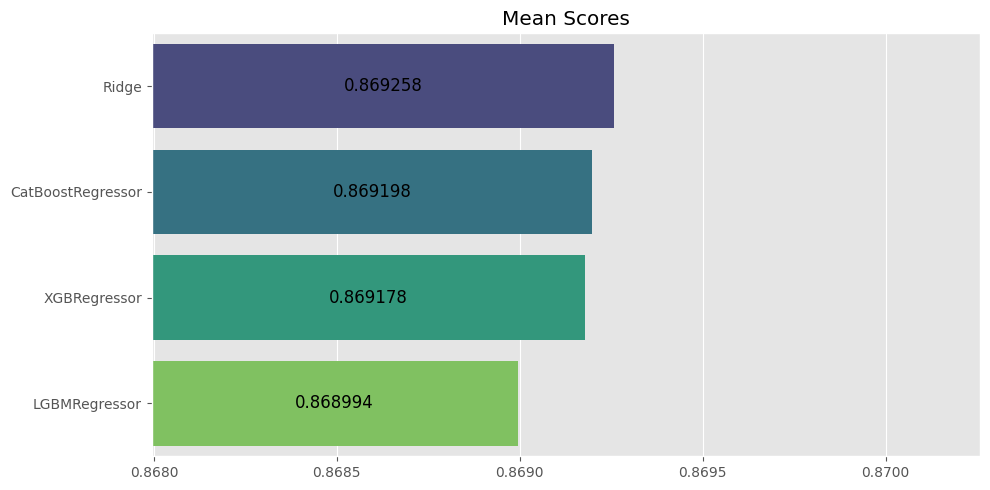

In [11]:
scores = pd.DataFrame({
    xgb_model.__class__.__name__: xgb_scores,
    cb_model.__class__.__name__: cb_scores,
    lgbm_model.__class__.__name__: lgbm_scores,
    ridge_model.__class__.__name__: np.array([ridge_score] * 5)
})
scores = scores[scores.mean().sort_values(ascending=False).index]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
mean_scores = scores.mean().sort_values(ascending=False)
sns.barplot(x=mean_scores, y=mean_scores.index, orient='h', ax=ax, palette='viridis')
ax.set_title('Mean Scores')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xlim(mean_scores.min() - 0.001, mean_scores.max() + 0.001)
for container in ax.containers:
    ax.bar_label(container, label_type='center', fontsize=12)
plt.tight_layout()
plt.show()

# Making Predictions

In [12]:
ridge_x_test = np.column_stack([
    Trainer(xgb_model, X, y).predict(test), 
    Trainer(cb_model, X, y).predict(test),
    Trainer(lgbm_model, X, y).predict(test), 
])

In [13]:
y_pred = ridge_model.predict(ridge_x_test)
submission = pd.DataFrame({'id': test.index, target_col: y_pred})
submission.to_csv(f'ensemble.csv', index=False)
submission.head()

,id,FloodProbability
0,1117957,0.578475
1,1117958,0.456428
2,1117959,0.448360
3,1117960,0.466578
4,1117961,0.466800
